In [2]:
import numpy as np # linear algebra
import json
from matplotlib import pyplot as plt
from skimage import color
from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score
from sklearn.svm import LinearSVC
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import math

import cv2 
from PIL import Image

import multiprocessing
from multiprocessing.pool import ThreadPool

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelBinarizer


In [9]:
def preprocess(image, cutoff=127, maxContours=5):
    image = np.uint8(image)
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image,connectivity = 4)
    sizes = stats[:,-1]
    max_label = 1
    max_size = sizes[1]
    for i in range(2,nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]
    img = np.zeros(output.shape)
    img[output == max_label] = 255
    return img

def preProcessImage(image, cutoff=127, maxContours=10):
    image = np.uint8(image)
    im = np.uint8(image)
    red, thresh = cv2.threshold(im, cutoff, 255, 0)
    im2, contours, hierarchy= cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros(im.shape, np.uint8)
    largest_contours = sorted(contours, key=cv2.contourArea, reverse=True)
    for ind, contour in enumerate(largest_contours[:5]):
        x, y, w, h = cv2.boundingRect(contour)
        mask[y:y+h, x:x+w] = 255    
    filteredImage = cv2.bitwise_and(thresh, thresh, mask=mask)
    return filteredImage.reshape((image.shape))

def rmEmpty(img):
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img, connectivity=8)
    sizes = stats[1:, -1]; nb_components = nb_components - 1
    min_size = 50
    img2 = np.zeros((output.shape))
    for i in range(0, nb_components):
        if sizes[i] >= min_size:
            img2[output == i + 1] = 255
    return img2

def f1_svc(X,y,test_X,test_y,int_scal,maxIteration,ran_state,tolerence):
    clf = LinearSVC(intercept_scaling=int_scal,max_iter=maxIteration,random_state=ran_state, tol=tolerence)
    clf.fit( X,y )
    prediction = []
    for i in range(len(test_X)):
        predict = clf.predict([test_X[i]])[0]
        prediction.append(predict)
    true = 0
    for i in range(len(test_y)):
        if(prediction[i]==test_y[i]):
            true += 1
    return true

In [5]:
data = np.load("all/train_images.npy",encoding='bytes')
x = []

for image in data:
    image = image[1].reshape(100,100)
    image = preprocess(image)
    image = preProcessImage(image)
    image = rmEmpty(image)
    image = image.reshape(10000,1)
    image = np.squeeze(image)
    x.append(image)


labels = pd.read_csv("all/train_labels.csv")
y = []
for i in range(len(labels)):
    label = labels['Category'][i]
    y.append(label)


x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size = 0.1, random_state=30)

x_train_backup = x_train
x_validation_backup = x_validation
print('finished')

finished


In [10]:
#linear SVC
f1_yelp_svc = f1_svc(x_train,y_train,x_validation,y_validation,1,1000,0,1e-05)
print("finished")

finished


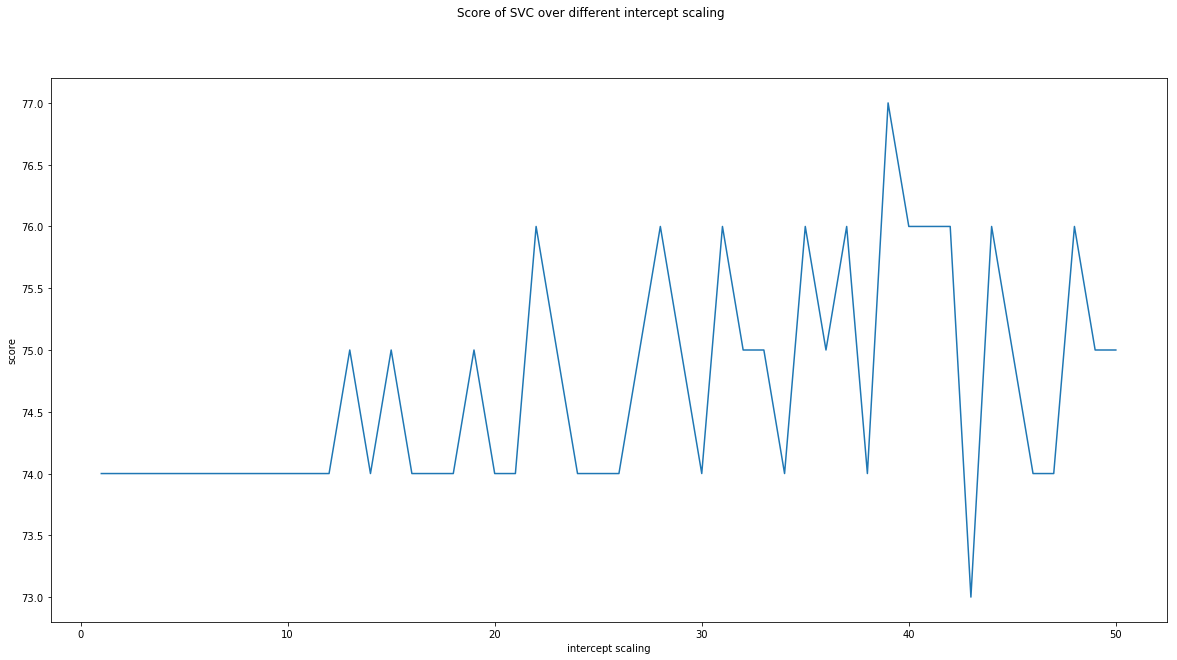

The best intercept scaling:  39
Best score:  77


In [14]:

is_increase = 1
test_is = 1
f1_yelp_svc_list_is = []
is_list = []
best_is = 0
best_f1_is = 0
for i in range(50):
    f1_yelp_svc = f1_svc(x_train,y_train,x_validation,y_validation,test_is,1000,0,1e-05)
    f1_yelp_svc_list_is.append(f1_yelp_svc)
    is_list.append(test_is)
    if(f1_yelp_svc > best_f1_is):
        best_f1_is = f1_yelp_svc
        best_is = test_is
    test_is = test_is + is_increase

fig = plt.figure(1,figsize=(20,10))
fig.suptitle('Score of SVC over different intercept scaling')
plt.plot(is_list,f1_yelp_svc_list_is)
plt.xlabel('intercept scaling')
plt.ylabel('score')
plt.show()
print('The best intercept scaling: ',best_is)
print('Best score: ',best_f1_is)

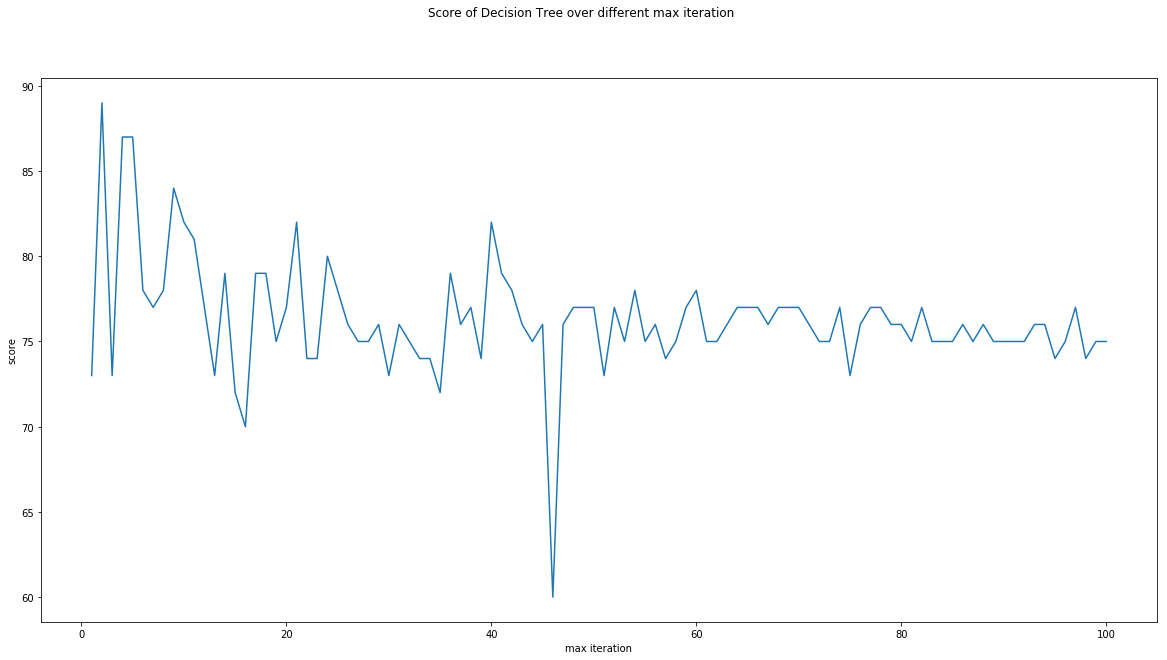

The best max iteration:  2
Best score:  89


In [15]:
#tune max iteration
iteration_increase = 1
test_iteration = 1
f1_yelp_svc_list_iteration = []
iteration_list = []
best_iteration = 0
best_f1_iteration = 0
for i in range(100):
    f1_yelp_svc = f1_svc(x_train,y_train,x_validation,y_validation,best_is,test_iteration,0,1e-05)
    f1_yelp_svc_list_iteration.append(f1_yelp_svc)
    iteration_list.append(test_iteration)
    if(f1_yelp_svc > best_f1_iteration):
        best_f1_iteration = f1_yelp_svc
        best_iteration = test_iteration
    test_iteration = test_iteration + iteration_increase

fig = plt.figure(2,figsize=(20,10))
fig.suptitle('Score of Decision Tree over different max iteration')
plt.plot(iteration_list,f1_yelp_svc_list_iteration)
plt.xlabel('max iteration')
plt.ylabel('score')
plt.show()
print('The best max iteration: ',best_iteration)
print('Best score: ',best_f1_iteration)